# PyTorch SRCNN Demo

epochs = 100 ; 為了只呈現 Code 而改成 epochs = 2

Reference : https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/

In [1]:
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate') 
        # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

Training samples:  16368
Validation samples:  5456
Computation device:  cpu
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)
Epoch 1 of 2


256it [00:52,  4.92it/s]                                                                                                                                                                                                                      
86it [00:05, 14.71it/s]                                                                                                                                                                                                                       


Train PSNR: 24.704
Val PSNR: 26.779
Epoch 2 of 2


256it [00:51,  4.96it/s]                                                                                                                                                                                                                      
86it [00:05, 14.65it/s]                                                                                                                                                                                                                       


Train PSNR: 26.814
Val PSNR: 27.172
Finished training in: 1.923 minutes


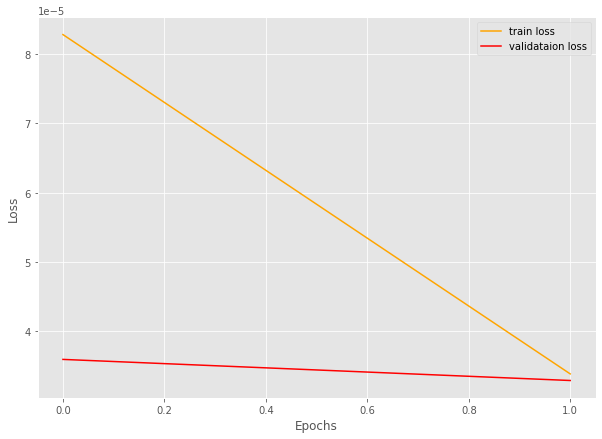

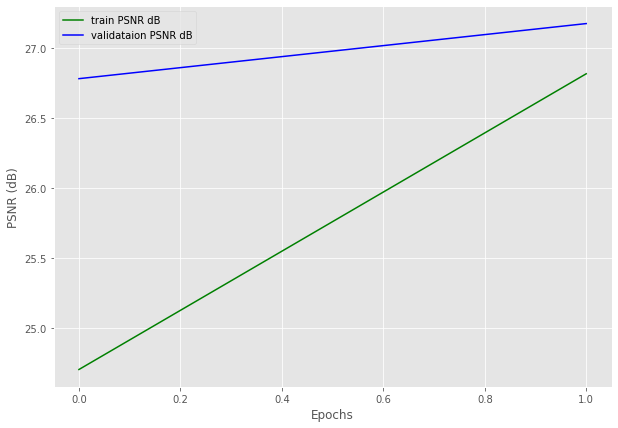

Saving model...


In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
# import srcnn
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 2
# epochs = 100
# number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# input image dimensions
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

# file = h5py.File('../input/train_mscale.h5')
file = h5py.File('./input/train_mscale.h5')
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel
in_train = file['data'][:] # the training data
out_train = file['label'][:] # the training labels
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

# the dataset module
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )


# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

# initialize the model
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR



def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr


def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"./outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr


train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./outputs/loss.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('./outputs/psnr.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), './outputs/model.pth')


In [3]:
import torch
import cv2
# import srcnn
import numpy as np
import glob as glob
import os
from torchvision.utils import save_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SRCNN().to(device)
model.load_state_dict(torch.load('./outputs/model.pth'))

image_paths = glob.glob('./input/bicubic_2x/*')
for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    test_image_name = image_path.split(os.path.sep)[-1].split('.')[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(image.shape[0], image.shape[1], 1)
    cv2.imwrite(f"./outputs/test_{test_image_name}.png", image)
    image = image / 255. # normalize the pixel values
    cv2.imshow('Greyscale image', image)
    cv2.waitKey(0)
    model.eval()
    with torch.no_grad():
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).to(device)
        image = image.unsqueeze(0)
        outputs = model(image)
    outputs = outputs.cpu()
    save_image(outputs, f"./outputs/output_{test_image_name}.png")
    outputs = outputs.detach().numpy()
    outputs = outputs.reshape(outputs.shape[2], outputs.shape[3], outputs.shape[1])
    print(outputs.shape)
    cv2.imshow('Output', outputs)
    cv2.waitKey(0)

(336, 228, 1)
(252, 252, 1)
(288, 288, 1)
(276, 276, 1)
(504, 504, 1)
